# Risk marker analysis - SHAP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV,RepeatedKFold, RepeatedStratifiedKFold, KFold, cross_val_score, StratifiedKFold, StratifiedShuffleSplit
import seaborn as sns
import os
import pickle
!pip3 install shap
import shap
shap.initjs()
import warnings
warnings.filterwarnings('ignore')


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
def read_data(raw_clinical_note):
    data = pd.read_csv(raw_clinical_note, header=0,na_filter=True)
    return data

def delete_columns(data,columns): 
    df = data.drop(columns,axis=1)
    return df

   
def plot_shap_values(model,X,feature_list,title,name, logs_file):
    explainer = shap.TreeExplainer(model.best_estimator_)
    shap_values = explainer.shap_values(X)
    plt.title(title)
    shap.summary_plot(shap_values, X, feature_names=feature_list, plot_type='bar',max_display=10)
    plt.title(title)
    shap.summary_plot(shap_values, X,feature_names=feature_list,show = 'False',max_display=10)
    
def plot_waterfall(model,X,id,name,logs_file):
    explainerModel_prob = shap.TreeExplainer(model.best_estimator_,
                                   data = shap.sample(X, 50),
                                   model_output='probability')
    

    shap_values_model_prob  = explainerModel_prob.shap_values(X)
    
    shap.plots._waterfall.waterfall_legacy(explainerModel_prob.expected_value,
                                           shap_values_model_prob[id,:],
                                           X.iloc[id,:],show=False,max_display=12)
    fig_name = name + '.pdf'
    url_save = os.path.join(logs_file,str(fig_name))
    plt.savefig(url_save,bbox_inches='tight')

    
def saving_model(model_ehr,model_name,logs_file):
    print("============= Saving model ================")
    file_out = os.path.join(logs_file,str(model_name))
    with open(file_out, 'wb') as modelfile:
        pickle.dump(model_ehr,modelfile)

In [3]:
raw_data = 'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/data_final_mor.csv'
data = pd.read_csv(raw_data)
print ("Total records", data.shape[0])

Total records 11564


In [4]:
X = data.drop(['Unnamed: 0','Mortality'],axis=1).astype(int)
y = data['Mortality'].astype(int) 
y = y.values.reshape(y.shape[0],1) 
feature_list = X.columns
print("X::", X.shape)
print("Y::", y.shape)

X:: (11564, 37)
Y:: (11564, 1)


In [5]:
data.columns

Index(['Unnamed: 0', 'Sex', 'Age', 'Pregnancy', 'Fever', 'Cough',
       'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea', 'Chest pain',
       'Chills', 'Headache', 'Myalgia', 'Arthralgia', 'General discomfort',
       'Rhinorrhea', 'Polypnea', 'Vomiting', 'Abdominal pain',
       'Conjunctivitis', 'Cyanosis', 'Sudden onset of symptoms', 'Anosmia',
       'Dysgeusia', 'Diabetes', 'COPD', 'Asthma', 'Immunosuppression',
       'Hypertension', 'HIV AIDS', 'Cardiovascular disease', 'Obesity', 'CKD',
       'Smoking', 'Puerperium', 'Use of antipyretics', 'Mortality',
       'Days elapsed'],
      dtype='object')

In [6]:
import joblib
XGB_loaded = joblib.load('C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/PKL/modelXGB1.pkl')

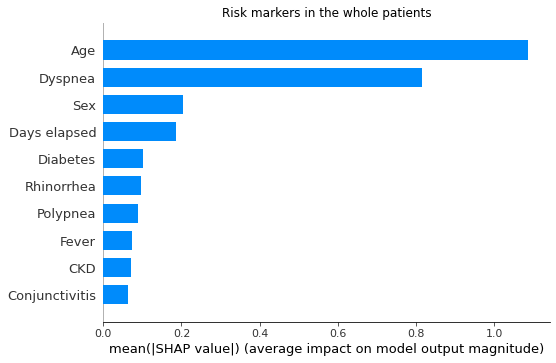

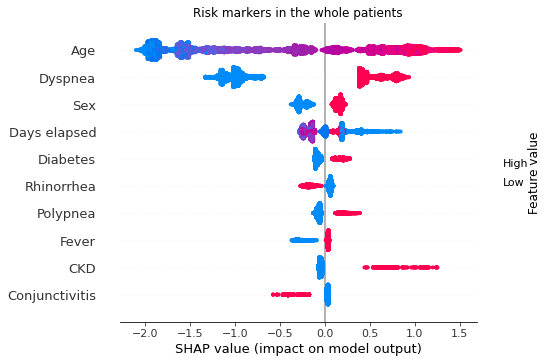

<Figure size 432x288 with 0 Axes>

In [7]:
title = "Risk markers in the whole patients"
plot_shap_values(XGB_loaded,X,feature_list,title,"Risk markers in the whole patients",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/risk')
plt.savefig('Risk_markers_in_the_whole_patients' , format='pdf', bbox_inches='tight')

# Analysis men

In [8]:
data_hombres = data[(data["Sex"]==1)] 
X_hombre = data_hombres.drop(['Unnamed: 0','Sex','Pregnancy','Puerperium','Mortality',],axis=1)
feature_list_hombres = X_hombre.columns
y_hombre = data_hombres['Mortality'].astype(int)
y_hombre = y_hombre.values.reshape(y_hombre.shape[0],1) 
print("X::", X_hombre.shape)
print("Y::", y_hombre.shape)
print(feature_list_hombres)

X:: (6245, 34)
Y:: (6245, 1)
Index(['Age', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability',
       'Diarrhea', 'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'HIV AIDS',
       'Cardiovascular disease', 'Obesity', 'CKD', 'Smoking',
       'Use of antipyretics', 'Days elapsed'],
      dtype='object')


In [9]:
def training(X,y,parameters,cv):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=242)
        
    ratio = float(np.sum(y_train == 0)) / np.sum(y_train==1)
    parameters=parameters
    sample_weights = np.ones(len(X_train))
    
    estimator = xgb.XGBClassifier(scale_pos_weight= ratio)
    
    grid = GridSearchCV(estimator=estimator, param_grid=parameters, cv = cv, scoring='roc_auc', refit = True)
    model = grid.fit(X_train,y_train,sample_weight = sample_weights)
    return model, X_test, y_test

[12:20:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[12:20:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[12:20:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[12:20:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[12:20:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

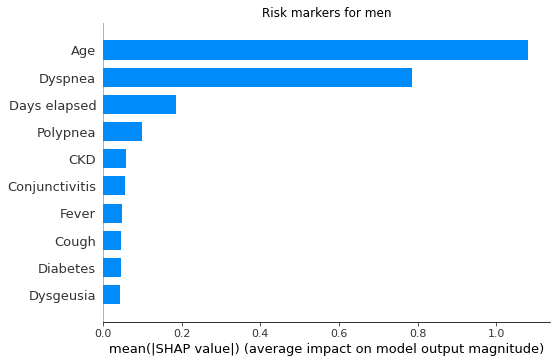

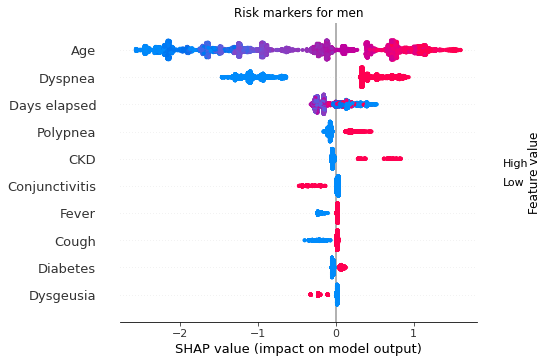

<Figure size 432x288 with 0 Axes>

In [10]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=442)
model_hombres,X_test_hombre, y_test_hombre = training(X_hombre,y_hombre,parameters,cv)

title = "Risk markers for men"
plot_shap_values(model_hombres,X_hombre,feature_list_hombres,title, "Risk markers for men",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/risk')
plt.savefig('Risk markers for men' , format='pdf', bbox_inches='tight')

In [11]:
saving_model(model_hombres,"modelXGB_men","C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/PKL")

============= Saving model ================


In [12]:
feature_important_hombres = model_hombres.best_estimator_.feature_importances_
feature_important_hombres = np.reshape(feature_important_hombres,(1,X_hombre.shape[1]))
df_feature_hombres = pd.DataFrame(feature_important_hombres,columns = feature_list_hombres)

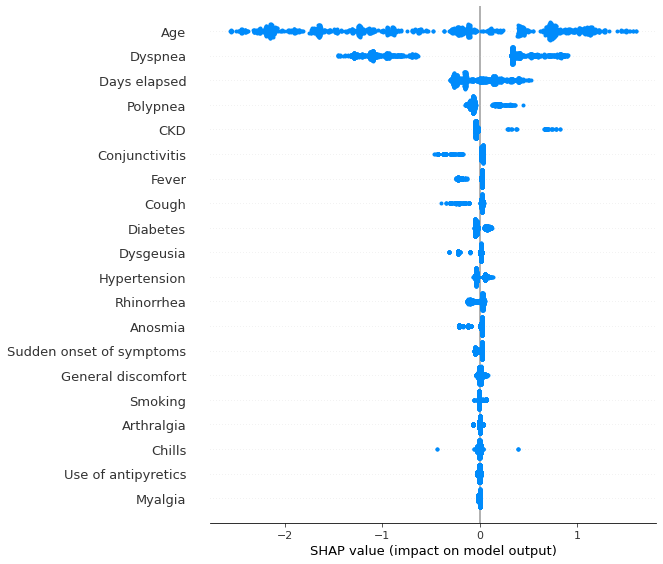

<Figure size 432x288 with 0 Axes>

In [13]:
explainer = shap.TreeExplainer(model_hombres.best_estimator_)
shap_values = explainer.shap_values(X_test_hombre)
shap.force_plot(explainer.expected_value, shap_values[200], X_test_hombre.iloc[200],show = True, feature_names=feature_list_hombres)
fig = shap.summary_plot(shap_values, feature_list_hombres)
plt.savefig('scratch.png')

# Analysis of men aged 20 to 29

In [14]:
data_hombres_edad_20_29 = data_hombres[(data_hombres["Age"]>=20) & ((data_hombres["Age"]<=29))]
X_hombre_edad_20_29 = data_hombres_edad_20_29.drop(['Unnamed: 0','Sex','Age','Pregnancy','Puerperium','Mortality',],axis=1)
y_hombre_edad_20_29 = data_hombres_edad_20_29['Mortality'].astype(int)
y_hombre_edad_20_29 = y_hombre_edad_20_29.values.reshape(y_hombre_edad_20_29.shape[0],1)
feature_list_hombres_edad_20_29 = X_hombre_edad_20_29.columns
print("X::", X_hombre_edad_20_29.shape)
print("Y::", y_hombre_edad_20_29.shape)
print(feature_list_hombres_edad_20_29)

X:: (657, 33)
Y:: (657, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'HIV AIDS',
       'Cardiovascular disease', 'Obesity', 'CKD', 'Smoking',
       'Use of antipyretics', 'Days elapsed'],
      dtype='object')


[12:20:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi


[12:20:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language b


[12:20:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language b

[12:20:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi


[12:20:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language b

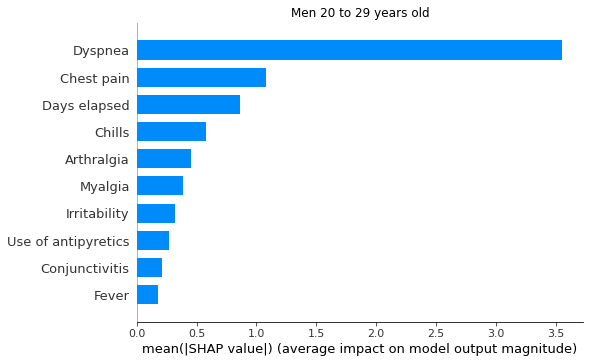

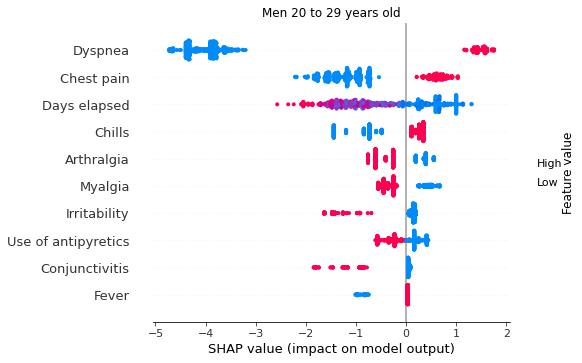

<Figure size 432x288 with 0 Axes>

In [15]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=442)
model_hombres_edad_20_29,X_test_hombre_edad_20_29, y_test_hombre_edad_20_29 = training(X_hombre_edad_20_29,y_hombre_edad_20_29,parameters,cv)

title = "Men 20 to 29 years old"
plot_shap_values(model_hombres_edad_20_29,X_hombre_edad_20_29,feature_list_hombres_edad_20_29,title,"Men 20 to 29 years old",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/risk')
plt.savefig('Men 20 to 29 years old' , format='pdf', bbox_inches='tight')

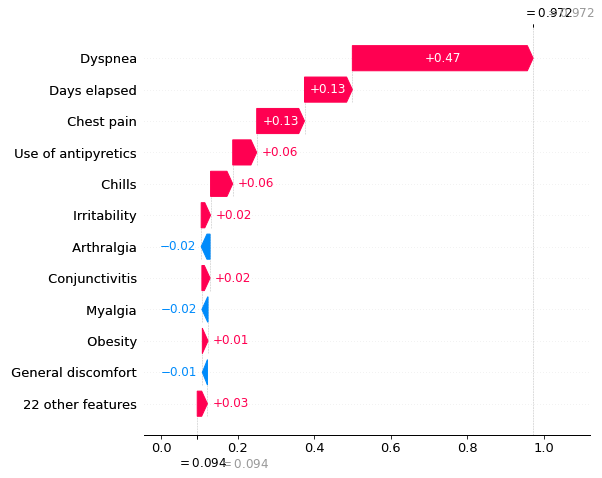

In [16]:
id = 15
plot_waterfall(model_hombres_edad_20_29,X_hombre_edad_20_29,id,"Male patient #15 20-29",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/waterfall')

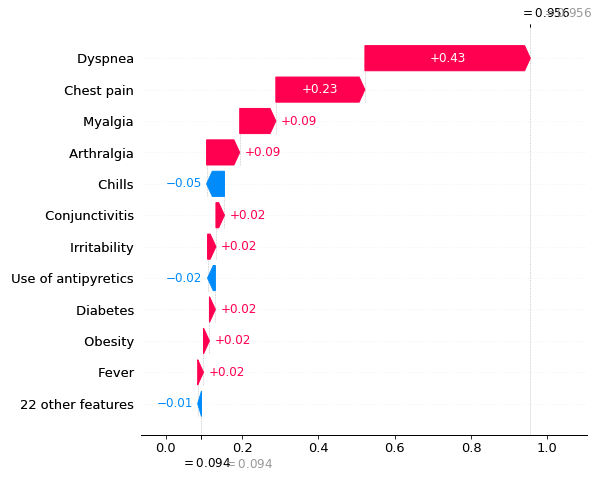

In [17]:
id = 148
plot_waterfall(model_hombres_edad_20_29,X_hombre_edad_20_29,id,"Male patient #148 20-29",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/waterfall')

# Analysis of men aged 30 to 39

In [18]:
data_hombres_edad_30_39 = data_hombres[(data_hombres["Age"]>=30) & ((data_hombres["Age"]<=39))]
X_hombre_edad_30_39 = data_hombres_edad_30_39.drop(['Unnamed: 0','Sex','Age','Pregnancy','Puerperium','Mortality',],axis=1)
y_hombre_edad_30_39 = data_hombres_edad_30_39['Mortality'].astype(int)
y_hombre_edad_30_39 = y_hombre_edad_30_39.values.reshape(y_hombre_edad_30_39.shape[0],1)
feature_list_hombres_edad_30_39 = X_hombre_edad_30_39.columns
print("X::", X_hombre_edad_30_39.shape)
print("Y::", y_hombre_edad_30_39.shape)
print(feature_list_hombres_edad_30_39)

X:: (1091, 33)
Y:: (1091, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'HIV AIDS',
       'Cardiovascular disease', 'Obesity', 'CKD', 'Smoking',
       'Use of antipyretics', 'Days elapsed'],
      dtype='object')


[12:20:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[12:20:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[12:20:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[12:20:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[12:20:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

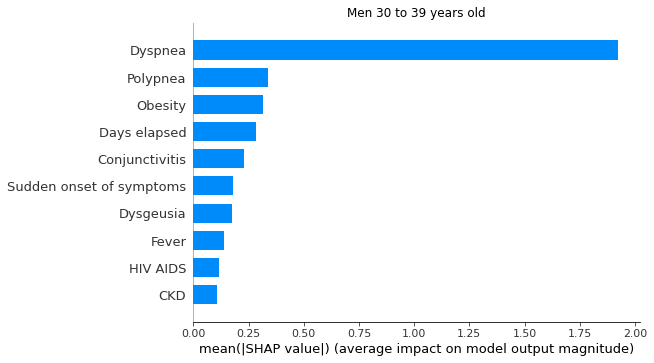

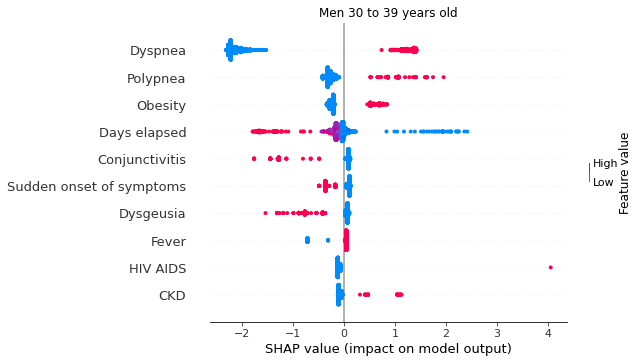

<Figure size 432x288 with 0 Axes>

In [19]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=442)
model_hombres_edad_30_39,X_test_hombre_edad_30_39, y_test_hombre_edad_30_39 = training(X_hombre_edad_30_39,y_hombre_edad_30_39,parameters,cv)

title = "Men 30 to 39 years old"
plot_shap_values(model_hombres_edad_30_39,X_hombre_edad_30_39,feature_list_hombres_edad_30_39,title,"Men 30 to 39 years old",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/risk')
plt.savefig('Men 30 to 39 years old' , format='pdf', bbox_inches='tight')

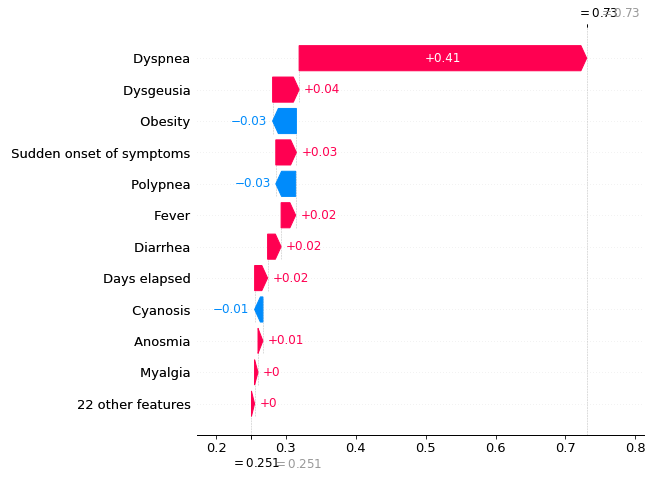

In [20]:
id = 1
plot_waterfall(model_hombres_edad_30_39,X_test_hombre_edad_30_39,id,"Male patient #1 30-39",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/waterfall')

# Analysis of men aged 40 to 49

In [21]:
data_hombres_edad_40_49 = data_hombres[(data_hombres["Age"]>=40) & ((data_hombres["Age"]<=49))] 
X_hombre_edad_40_49 = data_hombres_edad_40_49.drop(['Unnamed: 0','Sex','Age','Pregnancy','Puerperium','Mortality',],axis=1)
y_hombre_edad_40_49 = data_hombres_edad_40_49['Mortality'].astype(int)
y_hombre_edad_40_49 = y_hombre_edad_40_49.values.reshape(y_hombre_edad_40_49.shape[0],1) 
feature_list_hombres_edad_40_49 = X_hombre_edad_40_49.columns
print("X::", X_hombre_edad_40_49.shape)
print("Y::", y_hombre_edad_40_49.shape)
print(feature_list_hombres_edad_40_49)

X:: (1149, 33)
Y:: (1149, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'HIV AIDS',
       'Cardiovascular disease', 'Obesity', 'CKD', 'Smoking',
       'Use of antipyretics', 'Days elapsed'],
      dtype='object')


[12:20:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[12:20:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:20:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[12:21:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi


[12:21:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language b


[12:21:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language b

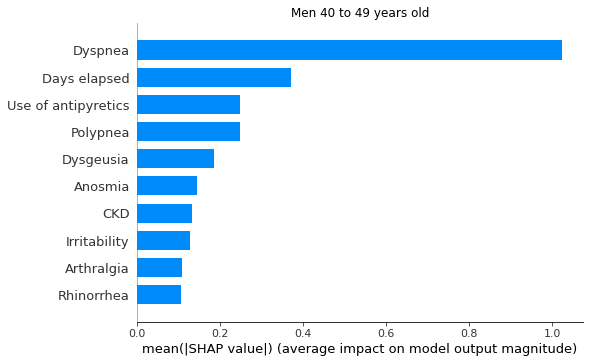

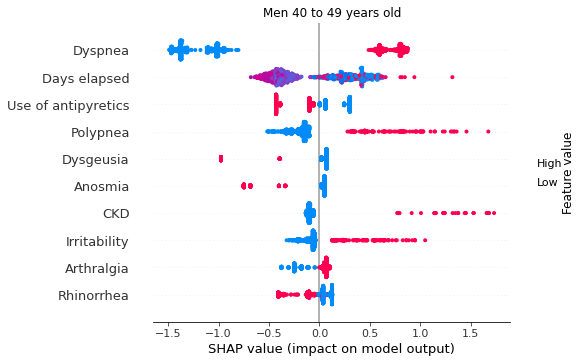

<Figure size 432x288 with 0 Axes>

In [22]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=442)
model_hombres_edad_40_49,X_test_hombre_edad_40_49, y_test_hombre_edad_40_49 = training(X_hombre_edad_40_49,y_hombre_edad_40_49,parameters,cv)

title = "Men 40 to 49 years old"
plot_shap_values(model_hombres_edad_40_49,X_hombre_edad_40_49,feature_list_hombres_edad_40_49,title,"Men 40 to 49 years old",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/risk')
plt.savefig('Men 40 to 49 years old' , format='pdf', bbox_inches='tight')

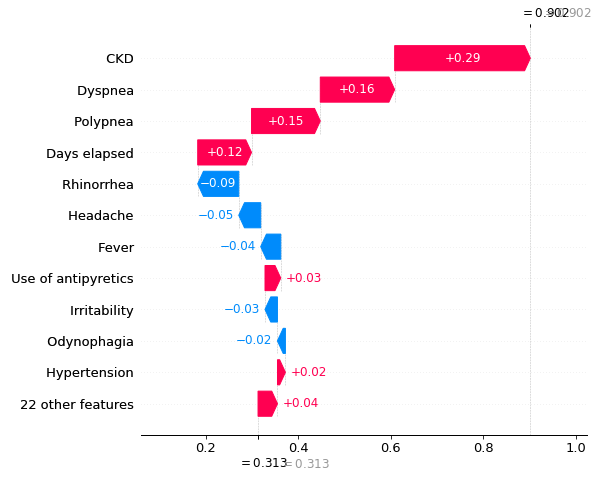

In [23]:
id = 176
plot_waterfall(model_hombres_edad_40_49,X_test_hombre_edad_40_49,id,"Male patient #176 40-49",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/waterfall')

# Analysis of men aged 50 to 59

In [24]:
data_hombres_edad_50_59 = data_hombres[(data_hombres["Age"]>=50) & ((data_hombres["Age"]<=59))] 
X_hombre_edad_50_59 = data_hombres_edad_50_59.drop(['Unnamed: 0','Sex','Age','Pregnancy','Puerperium','Mortality',],axis=1)
y_hombre_edad_50_59 = data_hombres_edad_50_59['Mortality'].astype(int)
y_hombre_edad_50_59 = y_hombre_edad_50_59.values.reshape(y_hombre_edad_50_59.shape[0],1) 
feature_list_hombres_edad_50_59 = X_hombre_edad_50_59.columns
print("X::", X_hombre_edad_50_59.shape)
print("Y::", y_hombre_edad_50_59.shape)
print(feature_list_hombres_edad_50_59)

X:: (1150, 33)
Y:: (1150, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'HIV AIDS',
       'Cardiovascular disease', 'Obesity', 'CKD', 'Smoking',
       'Use of antipyretics', 'Days elapsed'],
      dtype='object')


[12:21:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[12:21:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[12:21:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[12:21:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[12:21:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

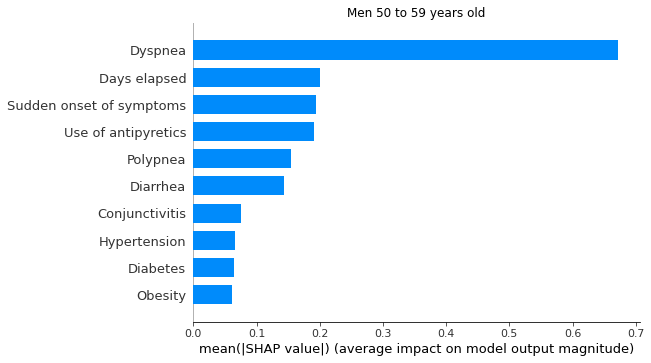

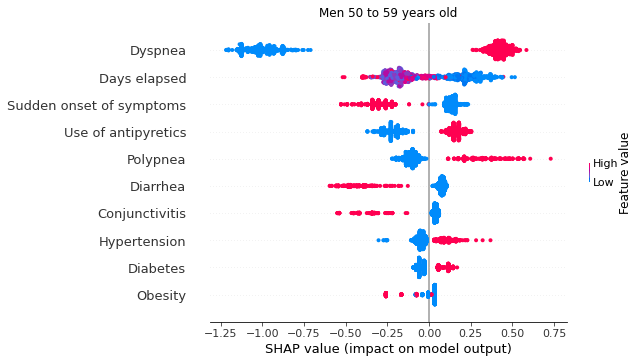

<Figure size 432x288 with 0 Axes>

In [25]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=442)
model_hombres_edad_50_59,X_test_hombre_edad_50_59, y_test_hombre_edad_50_59 = training(X_hombre_edad_50_59,y_hombre_edad_50_59,parameters,cv)

title = "Men 50 to 59 years old"
plot_shap_values(model_hombres_edad_50_59,X_hombre_edad_50_59,feature_list_hombres_edad_50_59,title, "Men 50 to 59 years old",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/risk')
plt.savefig('Men 50 to 59 years old' , format='pdf', bbox_inches='tight')

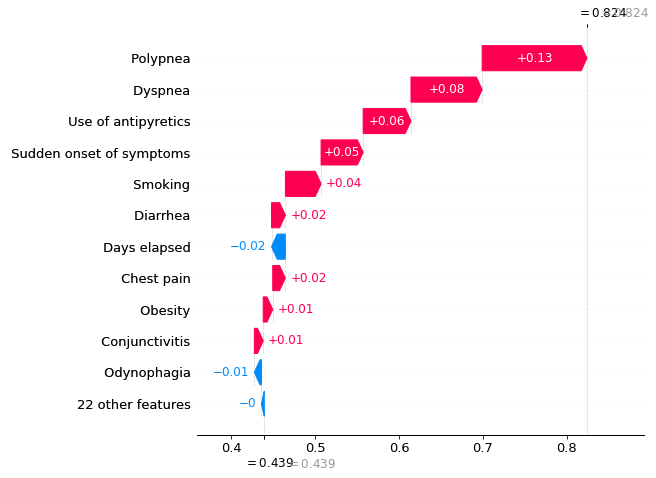

In [26]:
id = 91
plot_waterfall(model_hombres_edad_50_59,X_test_hombre_edad_50_59,id,"Male patient #91 50-59",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/waterfall')

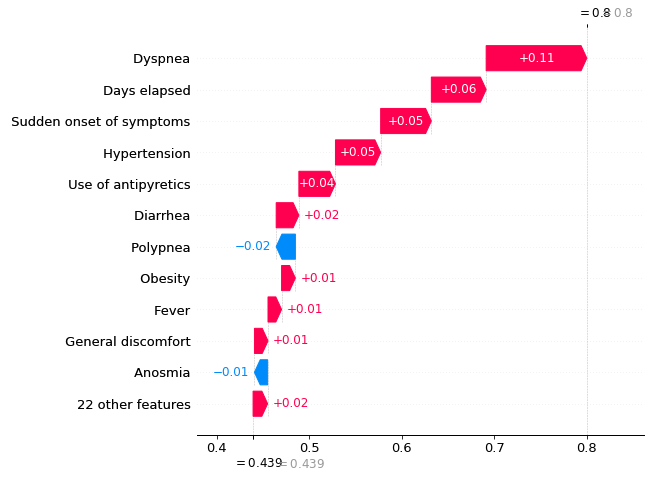

In [27]:
id = 101
plot_waterfall(model_hombres_edad_50_59,X_test_hombre_edad_50_59,id,"Male patient #101 50-59",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/waterfall')

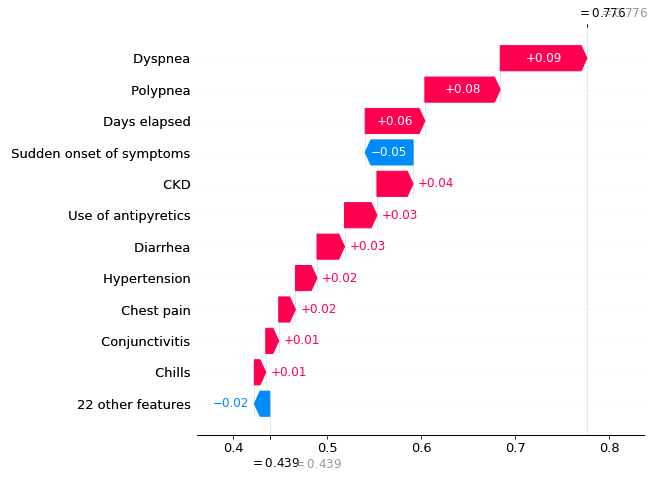

In [28]:
id = 182
plot_waterfall(model_hombres_edad_50_59,X_test_hombre_edad_50_59,id,"Male patient #182 50-59",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/waterfall')

# Analysis of men aged 60 to 69

In [29]:
data_hombres_edad_60_69 = data_hombres[(data_hombres["Age"]>=60) & ((data_hombres["Age"]<=69))]
X_hombre_edad_60_69 = data_hombres_edad_60_69.drop(['Unnamed: 0','Sex','Age','Pregnancy','Puerperium','Mortality',],axis=1)
y_hombre_edad_60_69 = data_hombres_edad_60_69['Mortality'].astype(int)
y_hombre_edad_60_69 = y_hombre_edad_60_69.values.reshape(y_hombre_edad_60_69.shape[0],1)
feature_list_hombres_edad_60_69 = X_hombre_edad_60_69.columns
print("X::", X_hombre_edad_60_69.shape)
print("Y::", y_hombre_edad_60_69.shape)
print(feature_list_hombres_edad_60_69)

X:: (1034, 33)
Y:: (1034, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'HIV AIDS',
       'Cardiovascular disease', 'Obesity', 'CKD', 'Smoking',
       'Use of antipyretics', 'Days elapsed'],
      dtype='object')


[12:21:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[12:21:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[12:21:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[12:21:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[12:21:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

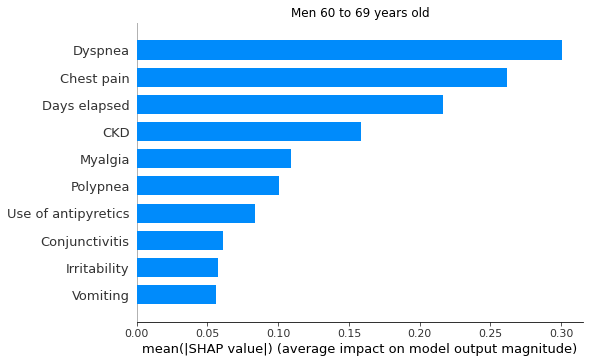

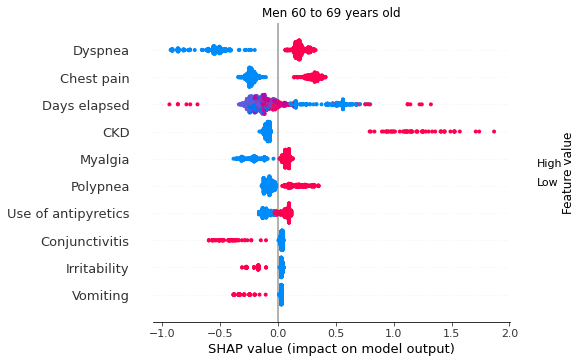

<Figure size 432x288 with 0 Axes>

In [30]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=442)
model_hombres_edad_60_69,X_test_hombre_edad_60_69, y_test_hombre_edad_60_69 = training(X_hombre_edad_60_69,y_hombre_edad_60_69,parameters,cv)

title = "Men 60 to 69 years old"
plot_shap_values(model_hombres_edad_60_69,X_hombre_edad_60_69,feature_list_hombres_edad_60_69,title,"Men 60 to 69 years old",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/risk')
plt.savefig('Men 60 to 69 years old' , format='pdf', bbox_inches='tight')

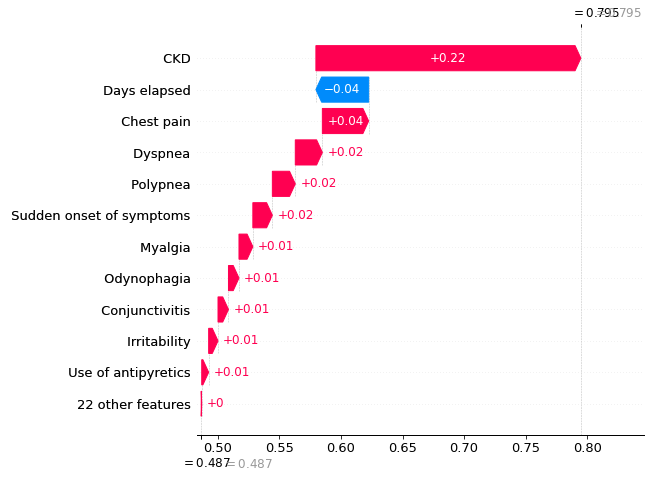

In [31]:
id = 206
plot_waterfall(model_hombres_edad_60_69,X_test_hombre_edad_60_69,id,"Male patient #206 60-69",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/waterfall')

# Analysis of men aged 70 and over

In [32]:
data_hombres_edad_70 = data_hombres[(data_hombres["Age"]>=70)]
X_hombre_edad_70 = data_hombres_edad_70.drop(['Unnamed: 0','Sex','Age','Pregnancy','Puerperium','Mortality',],axis=1)
y_hombre_edad_70 = data_hombres_edad_70['Mortality'].astype(int)
y_hombre_edad_70 = y_hombre_edad_70.values.reshape(y_hombre_edad_70.shape[0],1)
feature_list_hombres_edad_70 = X_hombre_edad_70.columns
print("X::", X_hombre_edad_70.shape)
print("Y::", y_hombre_edad_70.shape)
print(feature_list_hombres_edad_70)

X:: (1030, 33)
Y:: (1030, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'HIV AIDS',
       'Cardiovascular disease', 'Obesity', 'CKD', 'Smoking',
       'Use of antipyretics', 'Days elapsed'],
      dtype='object')


[12:21:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[12:21:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[12:21:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi


[12:21:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language b


[12:21:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language b

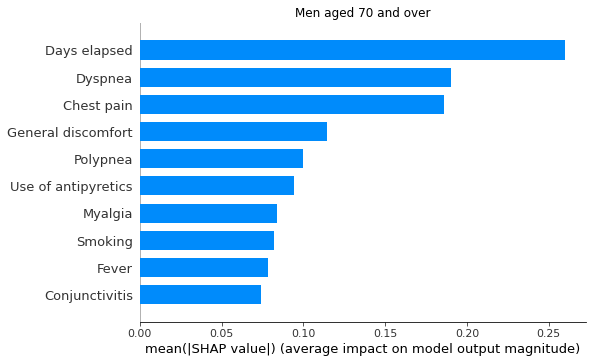

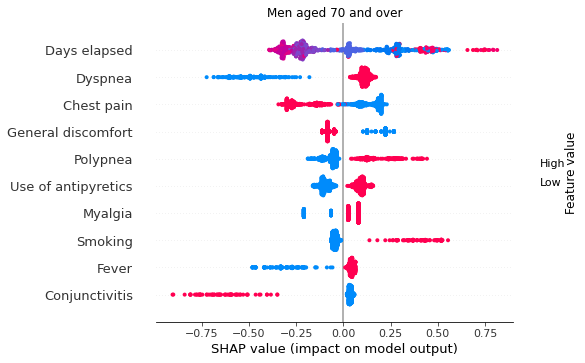

<Figure size 432x288 with 0 Axes>

In [33]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=442)
model_hombres_edad_70,X_test_hombre_edad_70, y_test_hombre_edad_70 = training(X_hombre_edad_70,y_hombre_edad_70,parameters,cv)

title = "Men aged 70 and over"
plot_shap_values(model_hombres_edad_70,X_hombre_edad_70,feature_list_hombres_edad_70,title,"Men 70 to 79 years old",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/risk')
plt.savefig('Men 70 to 79 years old' , format='pdf', bbox_inches='tight')

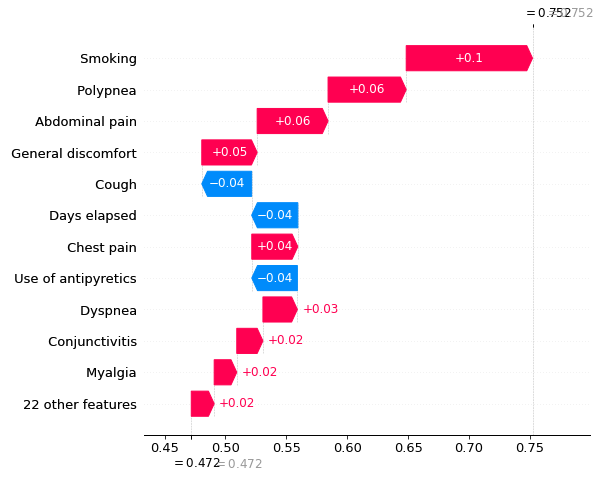

In [34]:
id = 39
plot_waterfall(model_hombres_edad_70, X_test_hombre_edad_70,id, "Male patient #39 70",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/waterfall')

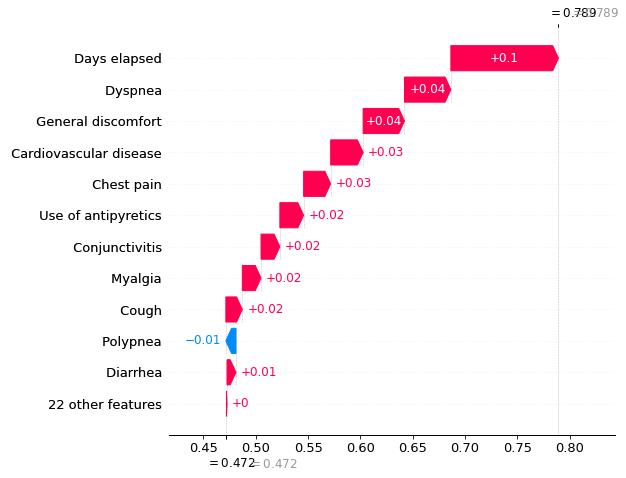

In [35]:
id = 46
plot_waterfall(model_hombres_edad_70, X_test_hombre_edad_70,id, "Male patient #46 70",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/waterfall')

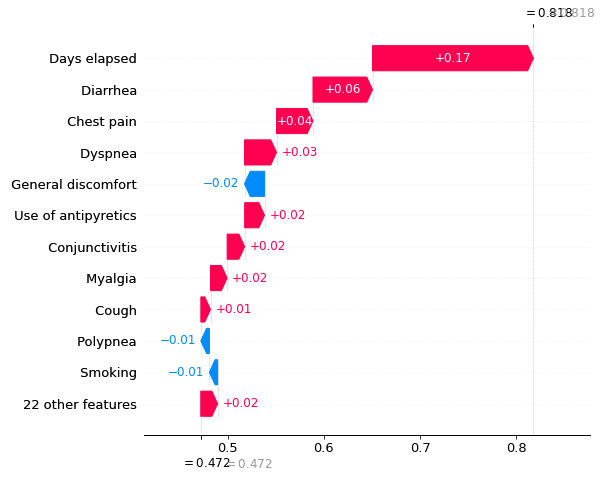

In [36]:
id = 78
plot_waterfall(model_hombres_edad_70, X_test_hombre_edad_70,id, "Male patient #78 70",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/waterfall')

# Analysis women

In [37]:
data_mujer = data[(data["Sex"]==0)] 
X_mujer = data_mujer.drop(['Unnamed: 0','Sex','Mortality',],axis=1)
y_mujer = data_mujer['Mortality'].astype(int)
y_mujer = y_mujer.values.reshape(y_mujer.shape[0],1) 
feature_list_mujer = X_mujer.columns
print("X::", X_mujer.shape)
print("Y::", y_mujer.shape)
print(feature_list_mujer)

X:: (5319, 36)
Y:: (5319, 1)
Index(['Age', 'Pregnancy', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea',
       'Irritability', 'Diarrhea', 'Chest pain', 'Chills', 'Headache',
       'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea', 'Polypnea',
       'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'HIV AIDS',
       'Cardiovascular disease', 'Obesity', 'CKD', 'Smoking', 'Puerperium',
       'Use of antipyretics', 'Days elapsed'],
      dtype='object')


[12:21:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:21:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[12:22:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[12:22:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[12:22:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi


[12:22:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language b

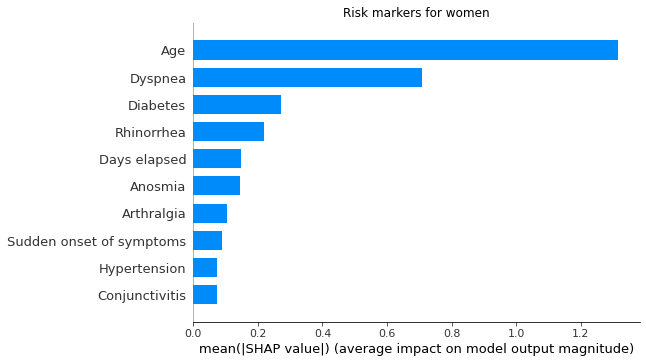

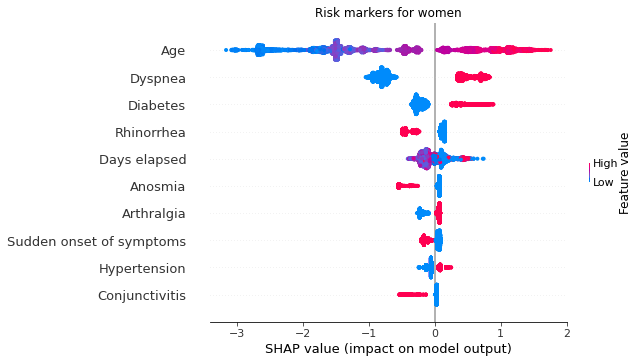

<Figure size 432x288 with 0 Axes>

In [38]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=442)
model_mujer,X_test_mujer, y_test_mujer = training(X_mujer,y_mujer,parameters,cv)

title = "Risk markers for women"
plot_shap_values(model_mujer,X_mujer,feature_list_mujer,title,"Women´s risk markers",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/risk')
plt.savefig('Risk markers for women', format='pdf', bbox_inches='tight')

In [39]:
saving_model(model_mujer,"modelXGB_women","C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/PKL")

============= Saving model ================


# Analysis of women aged 20 to 29

In [40]:
data_mujeres_edad_20_29 = data_mujer[(data_mujer["Age"]>=20) & ((data_mujer["Age"]<=29))]
X_mujer_edad_20_29 = data_mujeres_edad_20_29.drop(['Unnamed: 0','Sex','Age','Mortality',],axis=1)
y_mujer_edad_20_29 = data_mujeres_edad_20_29['Mortality'].astype(int)
y_mujer_edad_20_29 = y_mujer_edad_20_29.values.reshape(y_mujer_edad_20_29.shape[0],1)
feature_list_mujeres_edad_20_29 = X_mujer_edad_20_29.columns
print("X::", X_mujer_edad_20_29.shape)
print("Y::", y_mujer_edad_20_29.shape)
print(feature_list_mujeres_edad_20_29)

X:: (696, 35)
Y:: (696, 1)
Index(['Pregnancy', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability',
       'Diarrhea', 'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'HIV AIDS',
       'Cardiovascular disease', 'Obesity', 'CKD', 'Smoking', 'Puerperium',
       'Use of antipyretics', 'Days elapsed'],
      dtype='object')


# Analysis of women aged 30 to 39

In [41]:
data_mujeres_edad_30_39 = data_mujer[(data_mujer["Age"]>=30) & ((data_mujer["Age"]<=39))]
X_mujer_edad_30_39 = data_mujeres_edad_30_39.drop(['Unnamed: 0','Sex','Age','Mortality',],axis=1)
y_mujer_edad_30_39 = data_mujeres_edad_30_39['Mortality'].astype(int)
y_mujer_edad_30_39 = y_mujer_edad_30_39.values.reshape(y_mujer_edad_30_39.shape[0],1)
feature_list_mujeres_edad_30_39 = X_mujer_edad_30_39.columns
print("X::", X_mujer_edad_30_39.shape)
print("Y::", y_mujer_edad_30_39.shape)
print(feature_list_mujeres_edad_30_39)

X:: (1127, 35)
Y:: (1127, 1)
Index(['Pregnancy', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability',
       'Diarrhea', 'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'HIV AIDS',
       'Cardiovascular disease', 'Obesity', 'CKD', 'Smoking', 'Puerperium',
       'Use of antipyretics', 'Days elapsed'],
      dtype='object')


[12:22:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi


[12:22:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language b

[12:22:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi


[12:22:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language b

[12:22:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

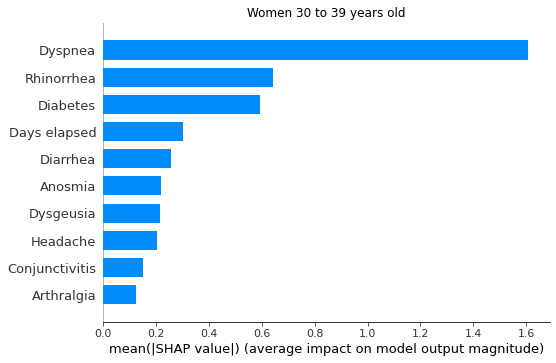

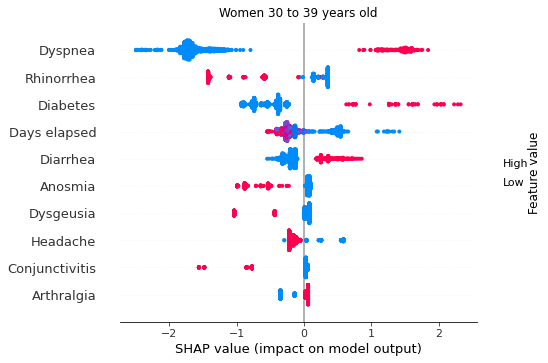

<Figure size 432x288 with 0 Axes>

In [42]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=442)
model_mujeres_edad_30_39,X_test_mujer_edad_30_39, y_test_mujer_edad_30_39 = training(X_mujer_edad_30_39,y_mujer_edad_30_39,parameters,cv)

title = "Women 30 to 39 years old"
plot_shap_values(model_mujeres_edad_30_39,X_mujer_edad_30_39,feature_list_mujeres_edad_30_39,title,"Women 30 to 39 years old",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/risk')
plt.savefig('Women 30 to 39 years old', format='pdf', bbox_inches='tight')

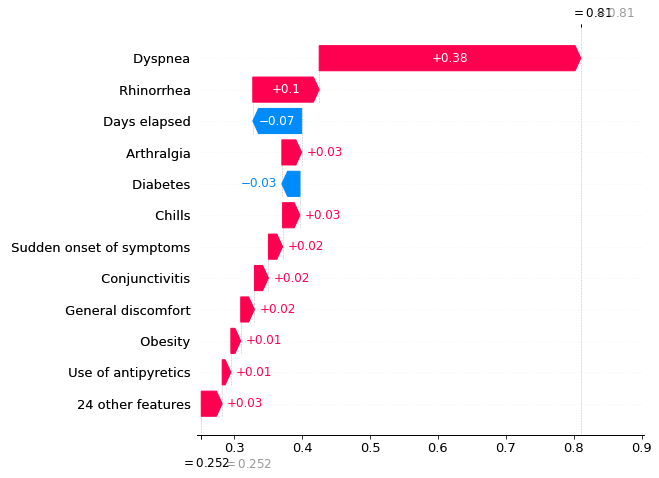

In [43]:
id = 25
plot_waterfall(model_mujeres_edad_30_39,X_test_mujer_edad_30_39,id,"Famale patient #25 30-39",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/waterfall')

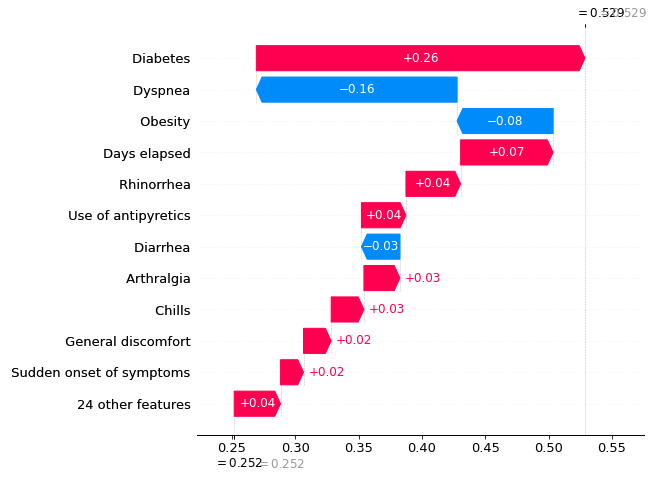

In [44]:
id = 201
plot_waterfall(model_mujeres_edad_30_39,X_test_mujer_edad_30_39,id,"Famale patient #201 30-39",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/waterfall')

# Analysis of women aged 40 to 49

In [45]:
data_mujeres_edad_40_49 = data_mujer[(data_mujer["Age"]>=40) & ((data_mujer["Age"]<=49))]
X_mujer_edad_40_49 = data_mujeres_edad_40_49.drop(['Unnamed: 0','Sex','Age','Mortality',],axis=1)
y_mujer_edad_40_49 = data_mujeres_edad_40_49['Mortality'].astype(int)
y_mujer_edad_40_49 = y_mujer_edad_40_49.values.reshape(y_mujer_edad_40_49.shape[0],1)
feature_list_mujeres_edad_40_49 = X_mujer_edad_40_49.columns
print("X::", X_mujer_edad_40_49.shape)
print("Y::", y_mujer_edad_40_49.shape)
print(feature_list_mujeres_edad_40_49)

X:: (1072, 35)
Y:: (1072, 1)
Index(['Pregnancy', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability',
       'Diarrhea', 'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'HIV AIDS',
       'Cardiovascular disease', 'Obesity', 'CKD', 'Smoking', 'Puerperium',
       'Use of antipyretics', 'Days elapsed'],
      dtype='object')


[12:22:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[12:22:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[12:22:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi


[12:22:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language b


[12:22:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language b

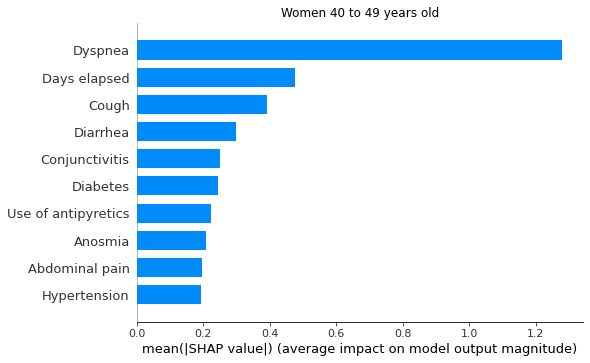

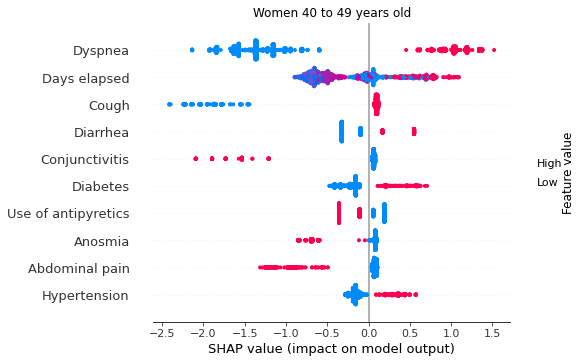

<Figure size 432x288 with 0 Axes>

In [46]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=442)
model_mujeres_edad_40_49,X_test_mujer_edad_40_49, y_test_mujer_edad_40_49 = training(X_mujer_edad_40_49,y_mujer_edad_40_49,parameters,cv)

title = "Women 40 to 49 years old"
plot_shap_values(model_mujeres_edad_40_49,X_mujer_edad_40_49,feature_list_mujeres_edad_40_49,title,"Women 40 to 49 years old",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/risk')
plt.savefig('Women 40 to 49 years old', format='pdf', bbox_inches='tight')

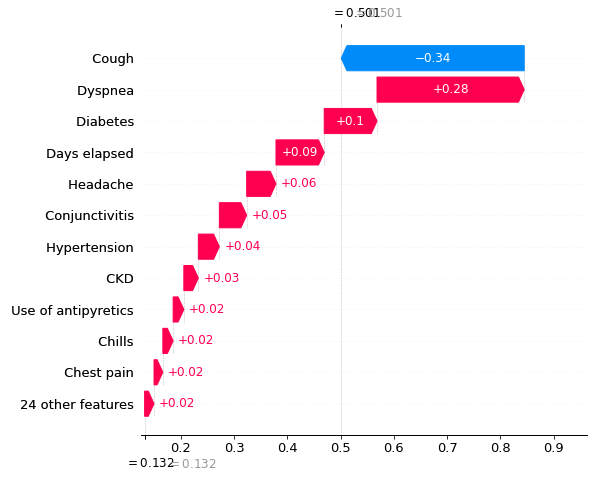

In [47]:
id = 68
plot_waterfall(model_mujeres_edad_40_49,X_test_mujer_edad_40_49,id,"Famale patient #68 40-49",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/waterfall')

# Analysis of women aged 50 to 59

In [48]:
data_mujeres_edad_50_59 = data_mujer[(data_mujer["Age"]>=50) & ((data_mujer["Age"]<=59))]
X_mujer_edad_50_59 = data_mujeres_edad_50_59.drop(['Unnamed: 0','Sex','Age','Mortality',],axis=1)
y_mujer_edad_50_59 = data_mujeres_edad_50_59['Mortality'].astype(int)
y_mujer_edad_50_59 = y_mujer_edad_50_59.values.reshape(y_mujer_edad_50_59.shape[0],1)
feature_list_mujeres_edad_50_59 = X_mujer_edad_50_59.columns
print("X::", X_mujer_edad_50_59.shape)
print("Y::", y_mujer_edad_50_59.shape)
print(feature_list_mujeres_edad_50_59)

X:: (951, 35)
Y:: (951, 1)
Index(['Pregnancy', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability',
       'Diarrhea', 'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'HIV AIDS',
       'Cardiovascular disease', 'Obesity', 'CKD', 'Smoking', 'Puerperium',
       'Use of antipyretics', 'Days elapsed'],
      dtype='object')


[12:22:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi


[12:22:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language b


[12:22:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language b


[12:22:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language b


[12:23:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:23:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:23:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language b

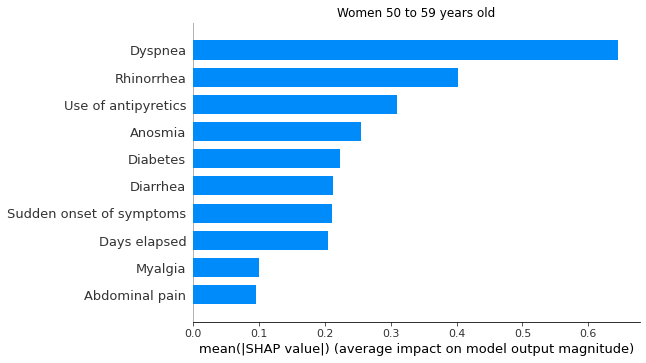

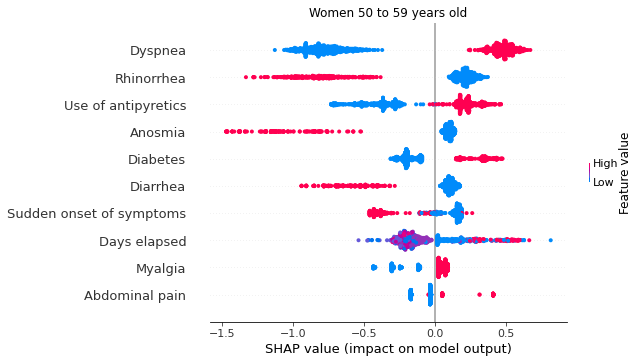

<Figure size 432x288 with 0 Axes>

In [49]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=442)
model_mujeres_edad_50_59,X_test_mujer_edad_50_59, y_test_mujer_edad_50_59 = training(X_mujer_edad_50_59,y_mujer_edad_50_59,parameters,cv)

title = "Women 50 to 59 years old"
plot_shap_values(model_mujeres_edad_50_59,X_mujer_edad_50_59,feature_list_mujeres_edad_50_59,title,"Women 50 to 59 years old",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/risk')
plt.savefig('Women 50 to 59 years old', format='pdf', bbox_inches='tight')

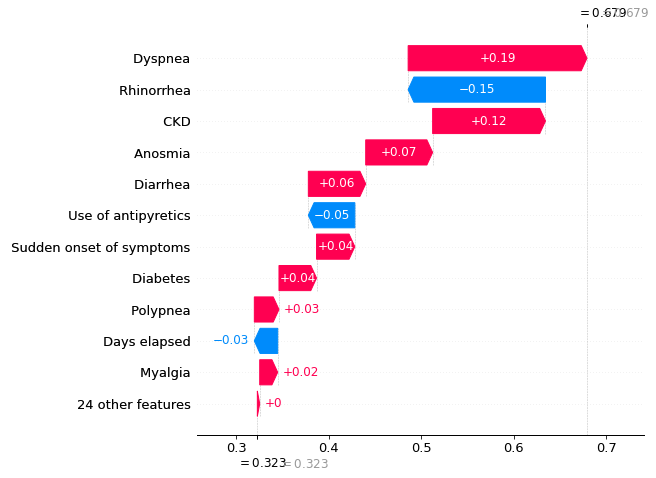

In [50]:
id = 24
plot_waterfall(model_mujeres_edad_50_59,X_test_mujer_edad_50_59,id,"Famale patient #24 50-59",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/waterfall')

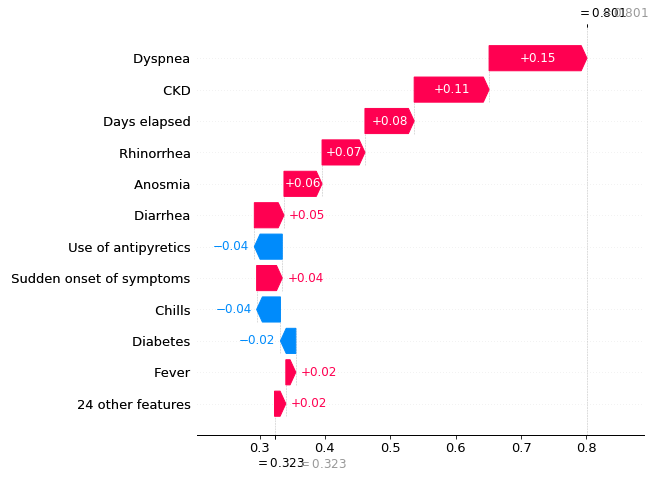

In [51]:
id = 37
plot_waterfall(model_mujeres_edad_50_59,X_test_mujer_edad_50_59,id,"Famale patient #37 50-59",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/waterfall')

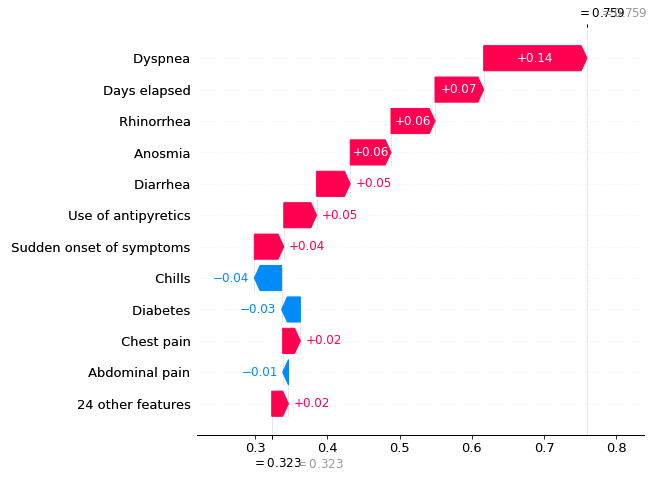

In [52]:
id = 166
plot_waterfall(model_mujeres_edad_50_59,X_test_mujer_edad_50_59,id,"Famale patient #166 50-59",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/waterfall')

# Analysis of women aged 60 to 69

In [53]:
data_mujeres_edad_60_69 = data_mujer[(data_mujer["Age"]>=60) & ((data_mujer["Age"]<=69))]
X_mujer_edad_60_69 = data_mujeres_edad_60_69.drop(['Unnamed: 0','Sex','Age','Mortality',],axis=1)
y_mujer_edad_60_69 = data_mujeres_edad_60_69['Mortality'].astype(int)
y_mujer_edad_60_69 = y_mujer_edad_60_69.values.reshape(y_mujer_edad_60_69.shape[0],1) 
feature_list_mujeres_edad_60_69 = X_mujer_edad_60_69.columns
print("X::", X_mujer_edad_60_69.shape)
print("Y::", y_mujer_edad_60_69.shape)
print(feature_list_mujeres_edad_60_69)

X:: (700, 35)
Y:: (700, 1)
Index(['Pregnancy', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability',
       'Diarrhea', 'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'HIV AIDS',
       'Cardiovascular disease', 'Obesity', 'CKD', 'Smoking', 'Puerperium',
       'Use of antipyretics', 'Days elapsed'],
      dtype='object')


[12:23:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:23:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:23:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[12:23:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:23:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:23:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi


[12:23:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:23:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:23:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language b

[12:23:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:23:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:23:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi


[12:23:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:23:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:23:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language b

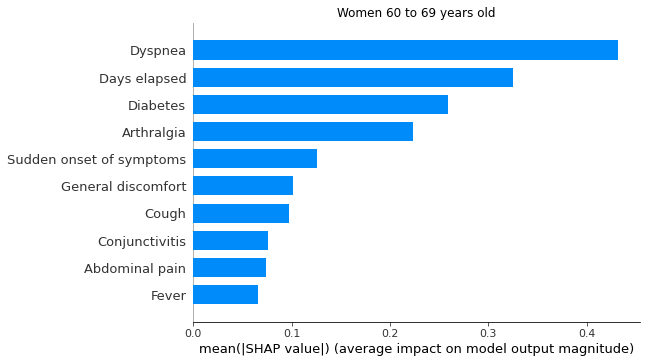

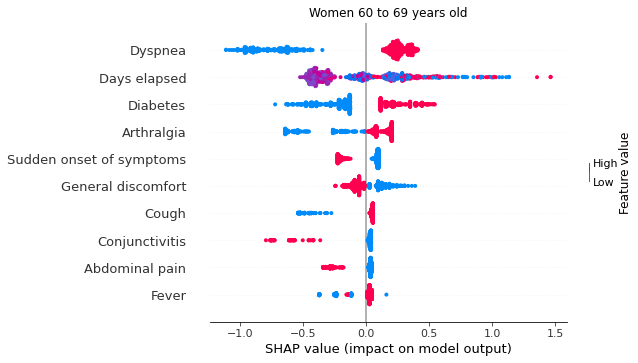

<Figure size 432x288 with 0 Axes>

In [54]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=442)
model_mujeres_edad_60_69,X_test_mujer_edad_60_69, y_test_mujer_edad_60_69 = training(X_mujer_edad_60_69,y_mujer_edad_60_69,parameters,cv)

title = "Women 60 to 69 years old"
plot_shap_values(model_mujeres_edad_60_69,X_mujer_edad_60_69,feature_list_mujeres_edad_60_69,title,"Women 60 to 69 years old",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/risk')
plt.savefig('Women 60 to 69 years old', format='pdf', bbox_inches='tight')

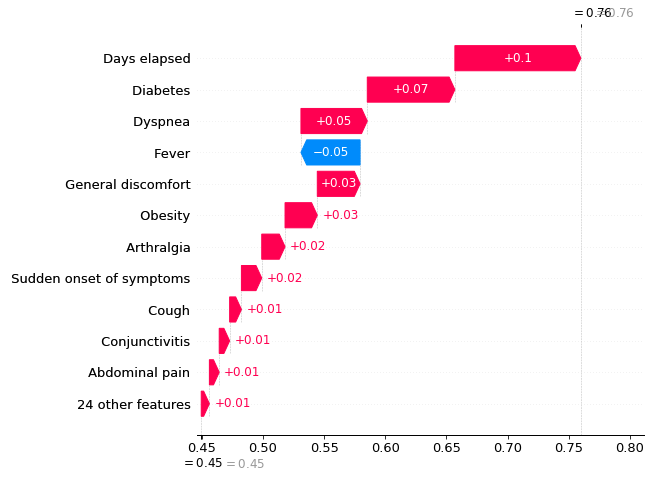

In [55]:
id = 23
plot_waterfall(model_mujeres_edad_60_69,X_test_mujer_edad_60_69,id,"Famale patient #23 60-69",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/waterfall')

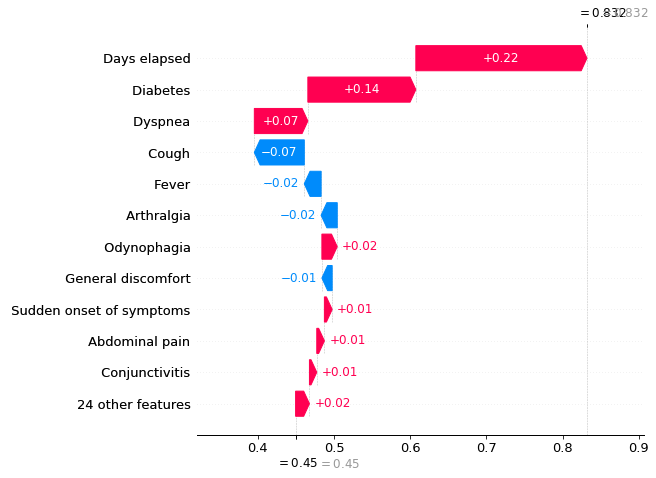

In [56]:
id = 44
plot_waterfall(model_mujeres_edad_60_69,X_test_mujer_edad_60_69,id,"Famale patient #44 60-69",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/waterfall')

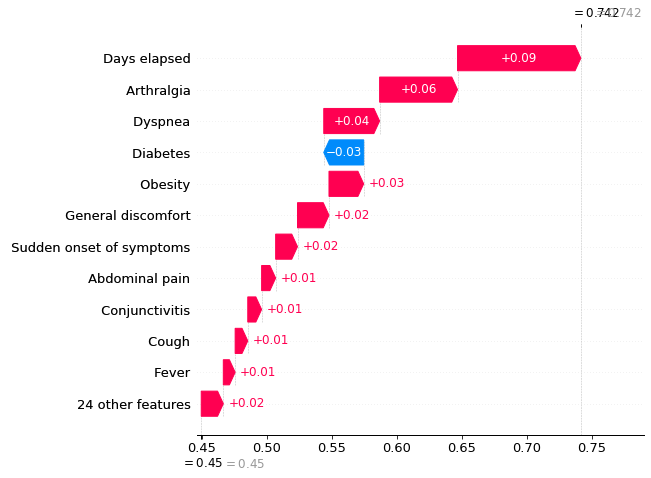

In [57]:
id = 59
plot_waterfall(model_mujeres_edad_60_69,X_test_mujer_edad_60_69,id,"Famale patient #59 60-69",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/waterfall')

# Analysis of women aged 70 and over

In [58]:
data_mujeres_edad_70 = data_mujer[(data_mujer["Age"]>=70)]
X_mujer_edad_70 = data_mujeres_edad_70.drop(['Unnamed: 0','Sex','Age','Mortality',],axis=1)
y_mujer_edad_70 = data_mujeres_edad_70['Mortality'].astype(int)
y_mujer_edad_70 = y_mujer_edad_70.values.reshape(y_mujer_edad_70.shape[0],1) 
feature_list_mujeres_edad_70 = X_mujer_edad_70.columns
print("X::", X_mujer_edad_70.shape)
print("Y::", y_mujer_edad_70.shape)
print(feature_list_mujeres_edad_70)

X:: (633, 35)
Y:: (633, 1)
Index(['Pregnancy', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability',
       'Diarrhea', 'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'HIV AIDS',
       'Cardiovascular disease', 'Obesity', 'CKD', 'Smoking', 'Puerperium',
       'Use of antipyretics', 'Days elapsed'],
      dtype='object')


[12:23:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:23:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:23:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[12:23:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:23:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:23:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[12:23:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:23:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:23:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi


[12:23:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:23:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:23:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language b

[12:23:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:23:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:23:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

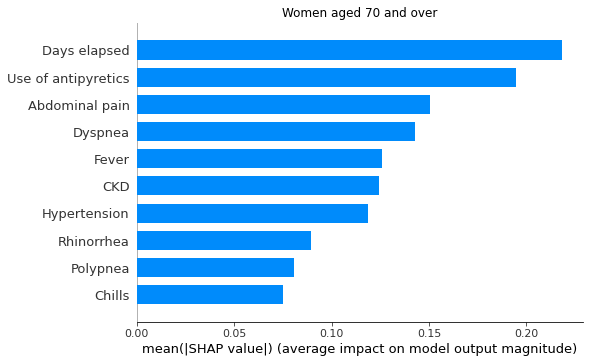

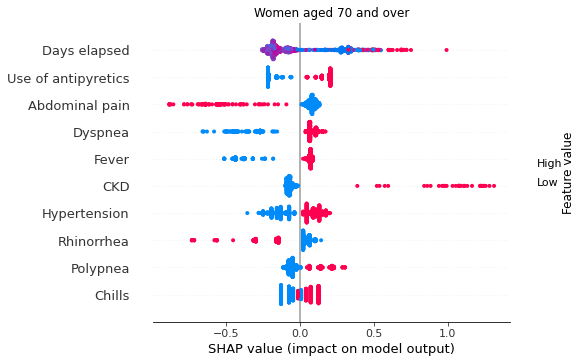

<Figure size 432x288 with 0 Axes>

In [59]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=442)
model_mujeres_edad_70,X_test_mujer_edad_70, y_test_mujer_edad_70 = training(X_mujer_edad_70,y_mujer_edad_70,parameters,cv)

title = "Women aged 70 and over"
plot_shap_values(model_mujeres_edad_70,X_mujer_edad_70,feature_list_mujeres_edad_70,title,"Women 70 to 79 years old",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/risk')
plt.savefig('Women aged 70 and over', format='pdf', bbox_inches='tight')

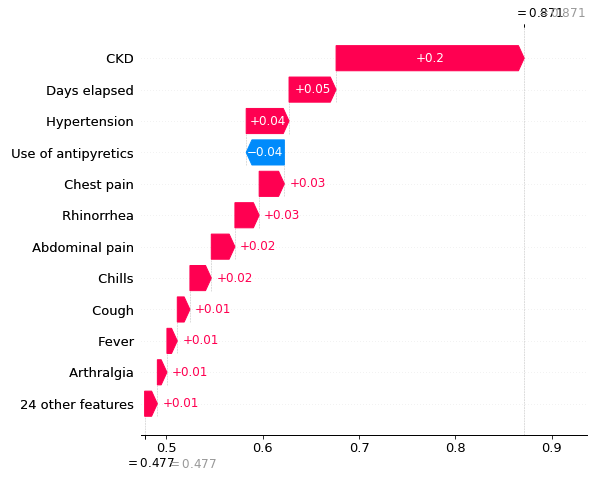

In [60]:
id = 32
plot_waterfall(model_mujeres_edad_70,X_test_mujer_edad_70,id,"Famale patient #32 70",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/waterfall')

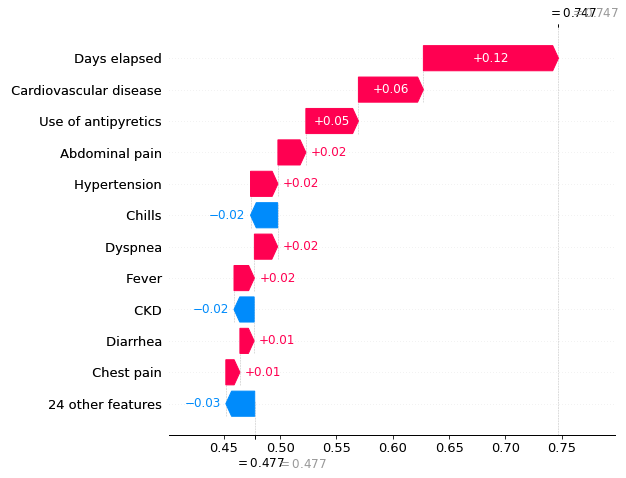

In [61]:
id = 37
plot_waterfall(model_mujeres_edad_70,X_test_mujer_edad_70,id,"Famale patient #37 70",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/waterfall')

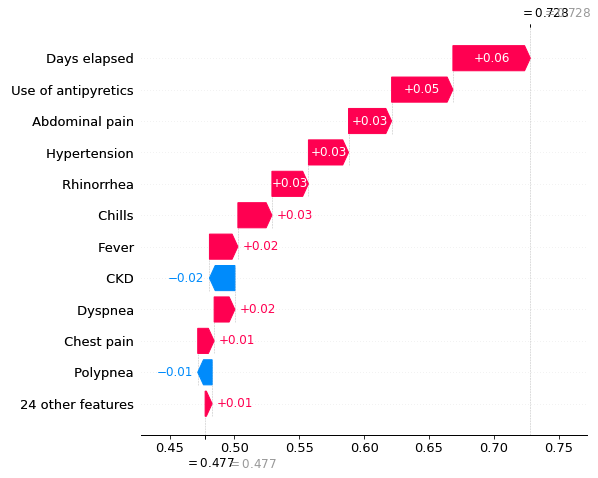

In [62]:
id = 92
plot_waterfall(model_mujeres_edad_70,X_test_mujer_edad_70,id,"Famale patient #92 70",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/waterfall')